In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [2]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
try:
    raw_df1 = pd.read_csv('../input/boston-house-prices/housing.csv', header = None, delimiter = r"\s+", names = column_names)
except:
    raw_df1 = pd.read_csv('housing.csv', header = None, delimiter = r"\s+", names = column_names)

In [3]:
raw_df1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [4]:
# CRIM рівень злочинності на душу населення за містами
# ZN частка житлової забудови, для ділянок площею понад 25 000 кв.м.
# INDUS частка площ під нероздрібну торгівлю за містом
# CHAS Річка Чарльз - фіктивна змінна (= 1, якщо урочище межує з річкою; 0 в іншому випадку)
# NOX концентрація оксидів азоту (частин на 10 мільйонів)
# RM середня кількість кімнат на одну оселю
# AGE частка власників житла, збудованого до 1940 року
# DIS середньозважена відстань до п'яти центрів зайнятості Бостона
# RAD індекс доступності до радіальних магістралей
# TAX ставка податку на повну вартість нерухомості на 10 000 доларів США
# PTRATIO співвідношення кількості учнів та вчителів у місті
# B 1000 (Bk - 0,63)^2 де Bk - частка темношкірого населення в місті
# LSTAT % нижчий статус населення
# MEDV Медіана вартості приватного житла у $1000
# Відсутні значення: Немає
# Повторювані значення: Немає

In [5]:
numeric_columns_boston = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

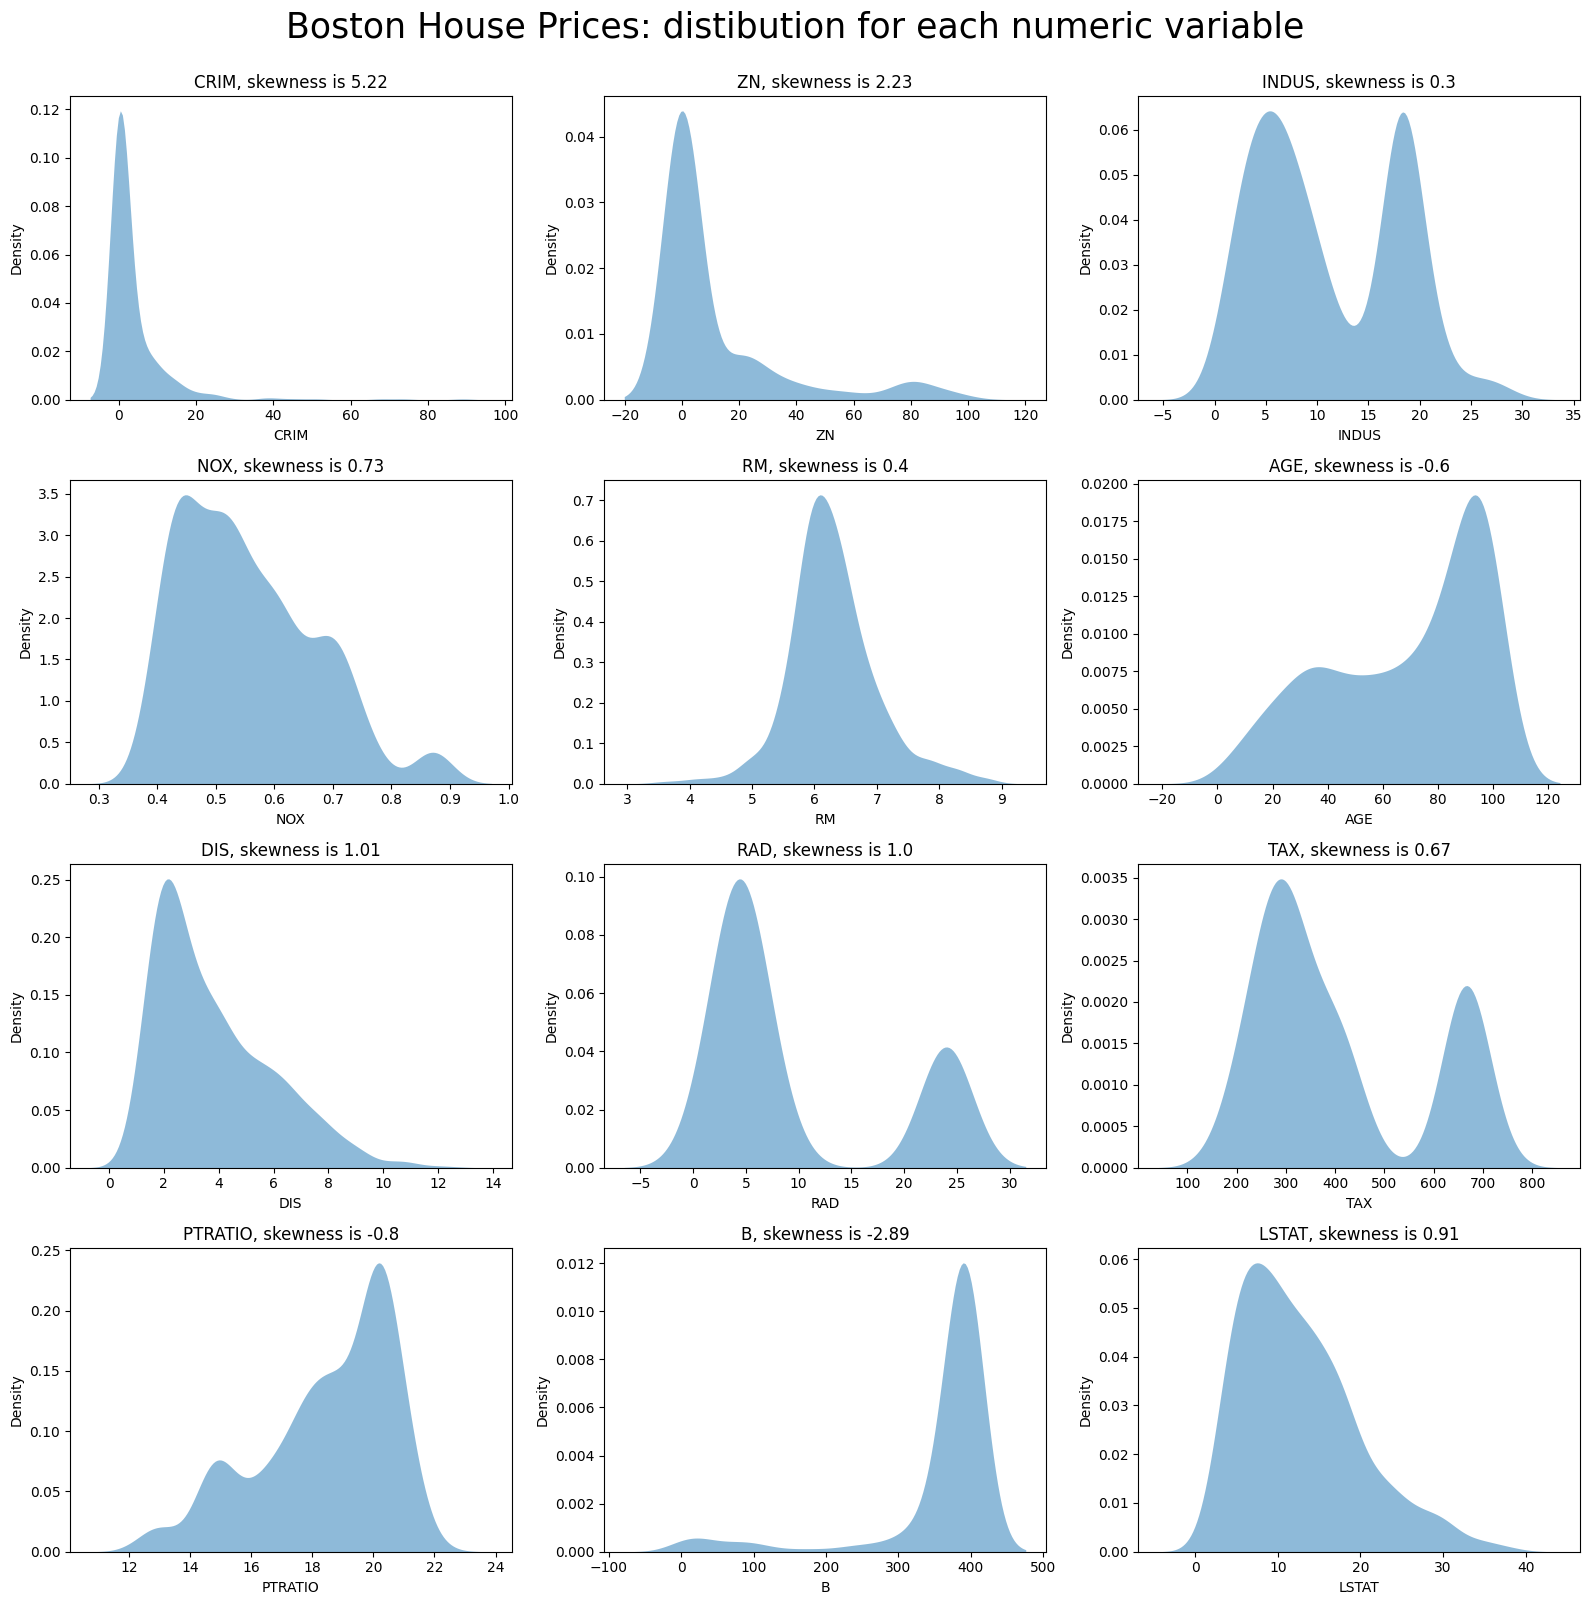

In [6]:
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(16,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True,  alpha=.5, linewidth=0)
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

dist_custom(dataset=raw_df1, columns_list=numeric_columns_boston, rows=4, cols=3, suptitle='Boston House Prices: distibution for each numeric variable')
plt.tight_layout()

In [7]:
def IQR_method (df,n,features):
    
    outlier_list = []
    
    for column in features:
                
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers:', df1.shape[0])
    
    return multiple_outliers

In [8]:
numeric_columns2 = ['CRIM', 'ZN', 'NOX', 'RM', 'AGE', 'DIS', 'PTRATIO', 'B', 'LSTAT']

Outliers_IQR = IQR_method(raw_df1,1,numeric_columns2)

df1 = raw_df1.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers: 7


In [9]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
    
    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    return R2, adjusted_r2, CV_R2, RMSE
    
    print('RMSE:', round(RMSE,4))
    print('R2:', round(R2,4))
    print('Adjusted R2:', round(adjusted_r2, 4) )
    print("Cross Validated R2: ", round(cv_score.mean(),4) )

In [10]:
X = raw_df1.iloc[:, :-1]
Y = raw_df1.iloc[:, -1]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class CustomLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X, y = check_X_y(X, y, accept_sparse=True)

        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]

        self.coef_ = np.linalg.inv(X.T @ X) @ X.T @ y

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X, accept_sparse=True)

        if self.fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]

        return X @ self.coef_

lm = CustomLinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

In [13]:
ndf = [Reg_Models_Evaluation_Metrics(lm,X_train,y_train,X_test,y_test,y_pred)]

lm_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
lm_score.insert(0, 'Model', 'Linear Regression')
lm_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Linear Regression,0.711226,0.684023,0.687535,4.63869


Text(0.5, 1.0, 'Linear regression for Boston House')

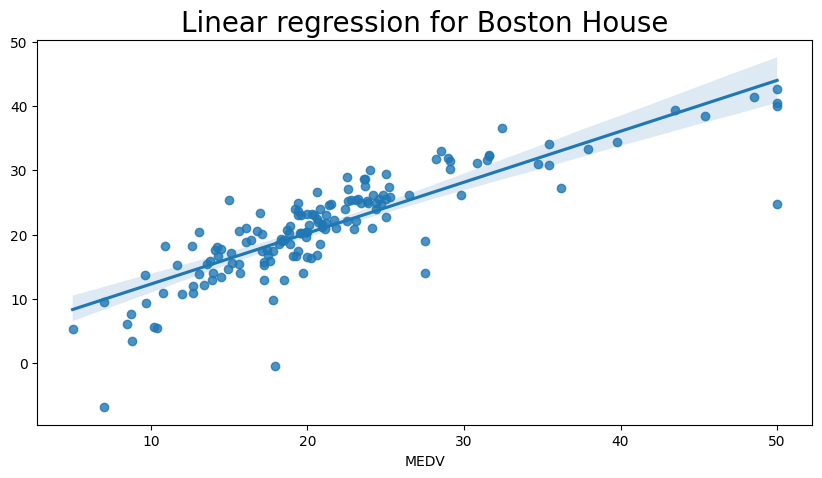

In [14]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression for Boston House', fontsize = 20)

In [15]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [16]:
Y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

In [17]:
from sklearn.ensemble import RandomForestRegressor

RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [18]:
RandomForest_reg.fit(X_train, y_train)

y_pred = RandomForest_reg.predict(X_test)

In [19]:
ndf = [Reg_Models_Evaluation_Metrics(RandomForest_reg,X_train,y_train,X_test,y_test,y_pred)]

rf_score1 = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rf_score1.insert(0, 'Model', 'Random Forest')
rf_score1

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest,0.85041,0.836318,0.816168,3.338627


Text(0.5, 1.0, 'Linear regression RF for Boston House')

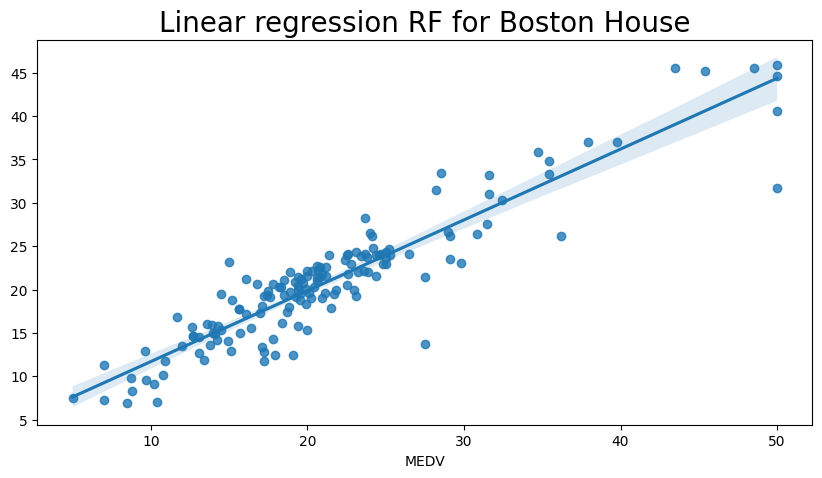

In [20]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression RF for Boston House', fontsize = 20)

In [21]:
y_pred

array([22.18, 30.27, 16.02, 22.9 , 17.22, 22.19, 20.66, 14.97, 21.2 ,
       20.63, 17.9 , 19.73,  7.27, 22.57, 19.32, 23.01, 18.01,  9.07,
       45.88, 14.85, 24.64, 23.49, 14.62, 23.45, 14.16, 13.63, 22.19,
       14.09, 19.53, 20.29, 19.26, 23.8 , 23.22, 21.44, 12.42, 15.85,
       35.8 , 18.75, 21.58, 23.86, 20.8 , 31.47, 44.64, 19.38, 21.78,
       12.9 , 14.49, 24.84, 18.37, 26.5 , 22.06, 34.81, 18.78, 24.11,
       45.54, 21.6 , 16.15, 33.43, 22.06, 21.08, 24.36, 33.35, 27.59,
       19.01, 26.16, 15.29, 12.67, 22.95, 26.36, 14.62, 21.57, 28.21,
       10.12, 22.72, 22.62,  7.5 , 19.57, 45.54, 11.77, 11.25, 21.79,
       11.8 , 19.08,  9.59, 21.5 , 26.58, 15.55, 22.91, 23.61, 18.08,
       21.97,  7.09, 19.6 , 19.27, 21.45, 19.96, 31.7 , 12.4 , 12.93,
       12.78, 20.56, 23.98, 13.5 , 20.12, 20.39, 11.92, 20.25, 23.93,
       19.57, 24.09,  9.75, 13.67, 22.22, 26.17, 33.19, 16.81, 36.97,
       15.93, 19.99, 24.07, 19.1 , 23.93,  8.27, 20.83, 23.99, 20.28,
       24.3 , 37.02,

In [22]:
import joblib

In [23]:
joblib.dump(lm, 'linear_regression_model.joblib')

['linear_regression_model.joblib']

In [24]:
loaded_model = joblib.load('linear_regression_model.joblib')

In [25]:
loaded_model

CustomLinearRegression()